# Apache Beam Demonstration with "Rain in Australia" Dataset

In this notebook, we'll delve into the core features of Apache Beam using the "Rain in Australia" dataset. Our goal is to demonstrate the capabilities of composite transforms, pipeline I/O, triggers, windowing, and `ParDo` using the Beam Python SDK.


In [2]:
# Installation of Apache Beam
!pip3 install apache-beam[interactive]

In [3]:
# Importing necessary libraries
import apache_beam as beam
from apache_beam import pvalue
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.io import ReadFromText, WriteToText
from apache_beam.transforms import window


In [4]:
# Path to the dataset
data_path = 'weatherAUS.csv'

In [5]:
# Define a composite transform to process rainfall data
class ProcessRainfallData(beam.PTransform):
    def expand(self, pcoll):
        return (pcoll
                | 'Parse CSV' >> beam.Map(lambda line: line.split(','))
                | 'Extract Rainfall Amount' >> beam.Map(lambda fields: float(fields[2]))  # assuming rainfall amount is the third column
                | 'Filter Valid Data' >> beam.Filter(lambda value: value > 0))


In [6]:
# Define a ParDo function to convert date string to timestamp
class ConvertDateToTimestamp(beam.DoFn):
    def process(self, element):
        from datetime import datetime
        date_str, rainfall = element
        timestamp = datetime.strptime(date_str, '%Y-%m-%d').timestamp()  # assuming date format is 'YYYY-MM-DD'
        yield timestamp, rainfall


In [10]:
options = PipelineOptions()

def valid_rainfall(element):
    _, rainfall = element
    return rainfall != 'NA'

with beam.Pipeline(options=options) as p:
    windowed_data = (
        p
        | 'Read Data' >> ReadFromText(data_path, skip_header_lines=1)
        | 'Parse CSV' >> beam.Map(lambda line: line.split(','))
        | 'Extract Date and Rainfall' >> beam.Map(lambda fields: (fields[0], fields[2]))  # assuming date is the first column and rainfall amount is the third column
        | 'Filter Out NA Rainfall' >> beam.Filter(valid_rainfall)
        | 'Convert Rainfall to Float' >> beam.Map(lambda fields: (fields[0], float(fields[1])))
        | 'Filter Valid Data' >> beam.Filter(lambda element: element[1] > 0)
        | 'Convert Date to Timestamp' >> beam.ParDo(ConvertDateToTimestamp())
        | 'Window' >> beam.WindowInto(window.FixedWindows(24*60*60))  # daily windows
        | 'Write results' >> WriteToText('windowed_output.txt')
    )


In [15]:
options = PipelineOptions()

def valid_rainfall(element):
    _, rainfall = element
    return rainfall != 'NA' and rainfall != 'MinTemp'  # Added condition to filter out header

with beam.Pipeline(options=options) as p:
    windowed_data = (
        p
        | 'Read Data' >> ReadFromText(data_path)
        | 'Parse CSV' >> beam.Map(lambda line: line.split(','))
        | 'Extract Date and Rainfall' >> beam.Map(lambda fields: (fields[0], fields[2]))  # assuming date is the first column and rainfall amount is the third column
        | 'Filter Out NA Rainfall' >> beam.Filter(valid_rainfall)
        | 'Convert Rainfall to Float' >> beam.Map(lambda fields: (fields[0], float(fields[1])))
        | 'Filter Valid Data' >> beam.Filter(lambda element: element[1] > 0)
        | 'Convert Date to Timestamp' >> beam.ParDo(ConvertDateToTimestamp())
        | 'Window' >> beam.WindowInto(window.FixedWindows(24*60*60))  # daily windows
        | 'Write results' >> WriteToText('windowed_output.txt')
    )

In [14]:
ls

beam-temp-output.txt-d1e2c940722a11ee8a240242ac1c000c/           weatherAUS.csv
beam-temp-windowed_output.txt-7682dac2722a11ee8a240242ac1c000c/  windowed_output.txt-00000-of-00001
sample_data/


In [16]:
import pandas as pd

# Read the output data
output_data = pd.read_csv('windowed_output.txt', header=None, names=['Timestamp', 'Rainfall'])

# Display the first few rows
output_data.head()


,Timestamp,Rainfall
0,(1228089600.0,13.4)
1,(1228176000.0,7.4)
2,(1228262400.0,12.9)
3,(1228348800.0,9.2)
4,(1228435200.0,17.5)


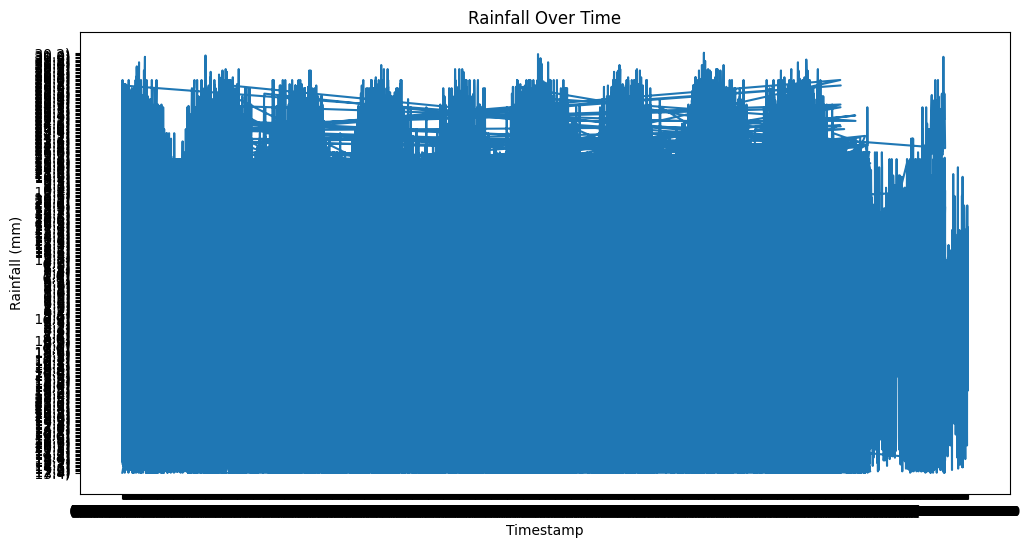

In [17]:
import matplotlib.pyplot as plt

# Visualize the Rainfall data
plt.figure(figsize=(12, 6))
plt.plot(output_data['Timestamp'], output_data['Rainfall'])
plt.title('Rainfall Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Rainfall (mm)')
plt.show()

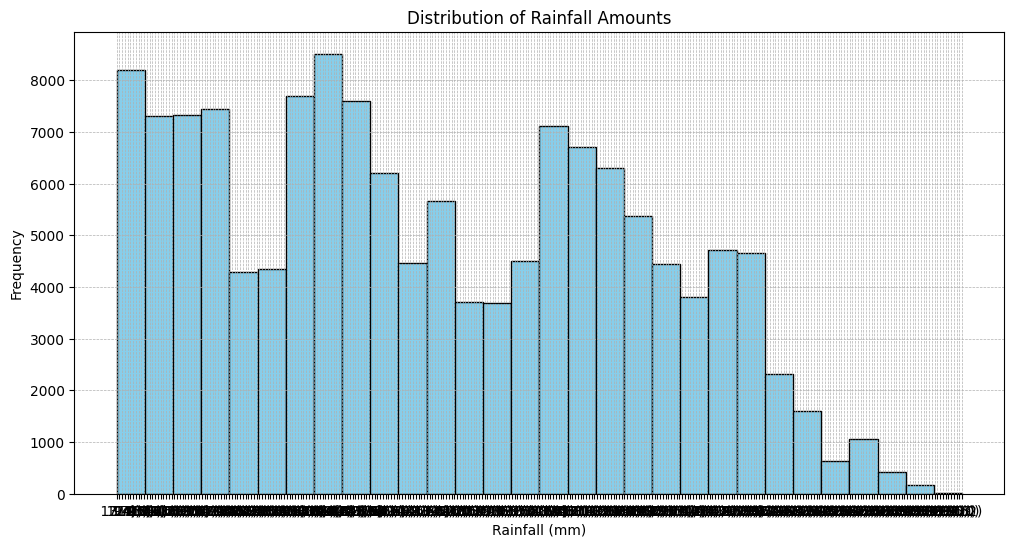

In [18]:
# Histogram of Rainfall Amounts
plt.figure(figsize=(12, 6))
plt.hist(output_data['Rainfall'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Rainfall Amounts')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


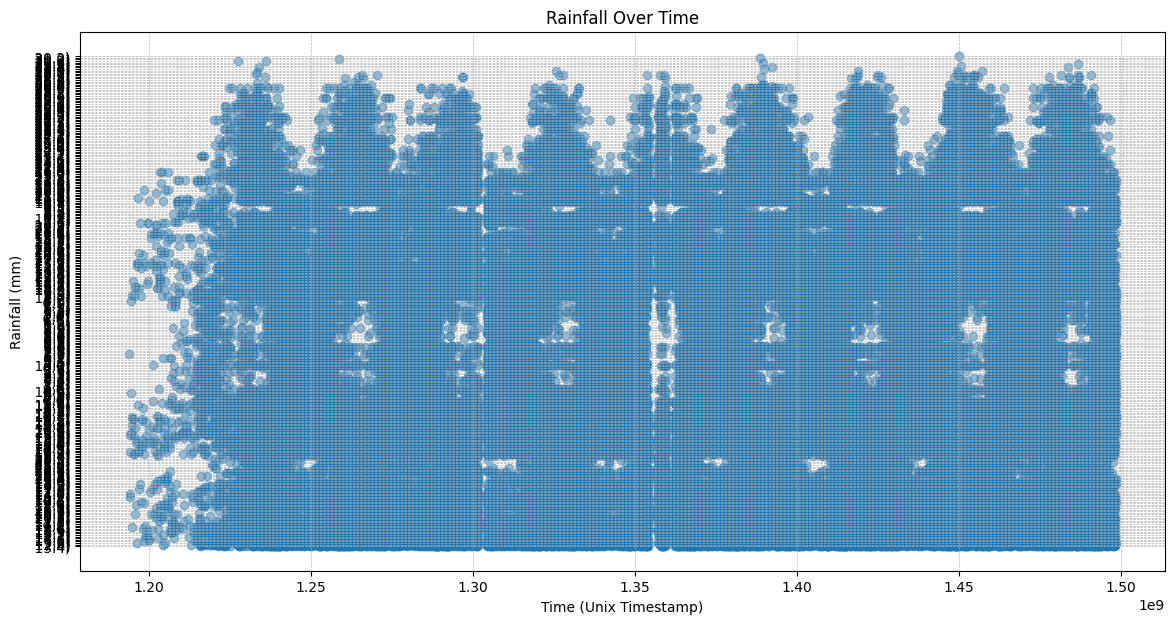

In [24]:
# Convert the cleaned string to float for x-axis
output_data['Float_Timestamp'] = output_data['Cleaned_Timestamp'].astype(float)

plt.figure(figsize=(14, 7))
plt.scatter(output_data['Float_Timestamp'], output_data['Rainfall'], alpha=0.5)
plt.title('Rainfall Over Time')
plt.xlabel('Time (Unix Timestamp)')
plt.ylabel('Rainfall (mm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


Through this notebook, we've explored the power and flexibility of Apache Beam. The "Rain in Australia" dataset was processed using various Beam transforms, showcasing how Beam can handle both batch and stream processing tasks with ease.
